# 畳み込みフィルターを用いた画像の分類

In [31]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import _pickle as pickle

np.random.seed(42)
tf.set_random_seed(42)

In [32]:
with open('ORENIST.data', 'rb') as file:
    images, labels = pickle.load(file, encoding='latin1')

In [33]:
def edge_filter():
    filter0 = np.array(
        [[ 2, 1, 0, -1, -2],
         [ 3, 2, 0, -2, -3],
         [ 4, 3, 0, -2, -4],
         [ 3, 2, 0, -2, -3],
         [ 2, 1, 0, -1, -2]]) / 23.0 #ブロードキャストルールで全体を/23.0
    
    filter1 = np.array(
        [[ 2, 3, 4, 3, 2],
         [ 1, 2, 3, 2, 1],
         [ 0, 0, 0, 0, 0],
         [-1,-2,0,-2,-1],
         [-2,-3,-4,-3,-2]]) / 23.0
    
    filter_array = np.zeros([5, 5, 1, 2])#フィルターの情報を格納しておく多次元リスト 5x5x1x2(フィルターサイズx入力レイヤー数x出力レイヤー数)
    filter_array[:,:,0,0] = filter0 #一番目の出力レイヤーのフィルターサイズの部分に格納
    filter_array[:,:,0,1] = filter1 #2番目の...
        
    return tf.constant(filter_array, dtype=tf.float32) # 用意した多次元リストをTensorFlowの定数値オブジェクトに変換したものを返している。
        

In [34]:
x = tf.placeholder(tf.float32, [None, 784])
x_image = tf.reshape(x, [-1, 28, 28, 1])

W_conv = edge_filter()
h_conv = tf.abs(tf.nn.conv2d(x_image, W_conv, strides = [1,1,1,1], padding='SAME'))

h_conv_cutoff = tf.nn.relu(h_conv-0.2)

h_pool = tf.nn.max_pool(h_conv_cutoff, ksize = [1,2,2,1], strides=[1,2,2,1], padding='SAME')

In [35]:
h_pool_flat = tf.reshape(h_pool, [-1, 392]) #ベクトルに変換(一行の行列に変換)

num_units1 = 392
num_units2 = 2

w2 = tf.Variable(tf.truncated_normal([num_units1, num_units2]))
b2 = tf.Variable(tf.zeros([num_units2]))
hidden2 = tf.nn.tanh(tf.matmul(h_pool_flat, w2) + b2)

w0 = tf.Variable(tf.zeros([num_units2, 3]))
b0 = tf.Variable(tf.zeros([3]))
p = tf.nn.softmax(tf.matmul(hidden2, w0) +b0)

In [36]:
t = tf.placeholder(tf.float32, [None, 3])
loss = - tf.reduce_sum(t * tf.log(p))
train_step = tf.train.AdamOptimizer().minimize(loss)
correct_prediction = tf.equal(tf.argmax(p, 1), tf.argmax(t, 1)) #tf.argmaxは第二引数に1を入れると行方向の一番大きい数字のindexを返す
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))# True or False を 1or0にキャスト

In [37]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

### Accuracyが伸びない時はKernelをReconnectする
原因はわからないがAccuracyが0.66つまり2/3の時は画像が1種欠けている

In [38]:
i = 0
for _ in range(200):
    i += 1
    sess.run(train_step, feed_dict = {x:images, t:labels})
    if i % 10 ==0:
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict = {x:images, t:labels})
        print('Step: %d, Loss: %f, Accuracy: %f' % (i, loss_val, acc_val))

Step: 10, Loss: 98.171188, Accuracy: 0.688889
Step: 20, Loss: 97.330765, Accuracy: 0.700000
Step: 30, Loss: 96.323135, Accuracy: 0.733333
Step: 40, Loss: 95.083107, Accuracy: 0.766667
Step: 50, Loss: 93.566849, Accuracy: 0.788889
Step: 60, Loss: 91.898178, Accuracy: 0.844444
Step: 70, Loss: 90.155716, Accuracy: 0.866667
Step: 80, Loss: 88.293488, Accuracy: 0.877778
Step: 90, Loss: 86.287170, Accuracy: 0.922222
Step: 100, Loss: 84.114830, Accuracy: 0.933333
Step: 110, Loss: 81.871559, Accuracy: 0.955556
Step: 120, Loss: 79.708672, Accuracy: 0.966667
Step: 130, Loss: 77.654785, Accuracy: 0.977778
Step: 140, Loss: 75.711777, Accuracy: 0.977778
Step: 150, Loss: 73.904289, Accuracy: 0.988889
Step: 160, Loss: 72.237602, Accuracy: 1.000000
Step: 170, Loss: 70.686607, Accuracy: 1.000000
Step: 180, Loss: 69.227425, Accuracy: 1.000000
Step: 190, Loss: 67.841629, Accuracy: 1.000000
Step: 200, Loss: 66.517006, Accuracy: 1.000000


z1,z2座標を見ると分類できていることがわかる。あとは平面上の分類と同じ作業

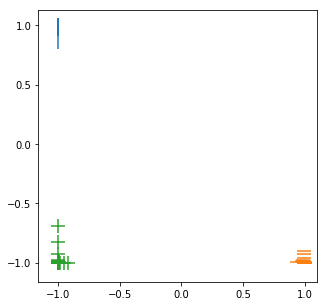

In [41]:
hidden2_vals = sess.run(hidden2, feed_dict={x:images})

z1_vals = [[], [], []]
z2_vals = [[], [], []]

for hidden2_val, label in zip(hidden2_vals, labels):
    label_num = np.argmax(label)
    z1_vals[label_num].append(hidden2_val[0])
    z2_vals[label_num].append(hidden2_val[1])
    
fig = plt.figure(figsize=(5,5))
subplot = fig.add_subplot(1,1,1)
subplot.scatter(z1_vals[0], z2_vals[0], s = 200, marker = '|')
subplot.scatter(z1_vals[1], z2_vals[1], s = 200, marker = '_')
subplot.scatter(z1_vals[2], z2_vals[2], s = 200, marker = '+')
plt.show()